<a href="https://colab.research.google.com/github/antounes/deep-learning-fastai-pytorch/blob/main/02_from_model_to_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
!pip install -q --upgrade git+https://github.com/fastai/fastai.git
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 189 kB 11.5 MB/s 
     |████████████████████████████████| 1.2 MB 38.2 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 51 kB 341 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
urls = search_images_ddg('grizzly bear', max_images=100)
len(urls), urls[0]

(100,
 'https://bloximages.chicago2.vip.townnews.com/codyenterprise.com/content/tncms/assets/v3/editorial/c/75/c75e6ae4-5ab0-11e7-9823-3b1d2aaec452/595173d52fa4e.image.jpg?resize=1200%2C885')

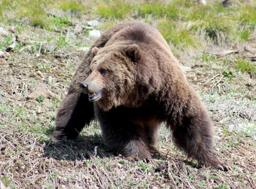

In [4]:
download_url(urls[0], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256, 256))
im

In [5]:
bear_types = ['grizzly', 'black', 'teddy']
path = Path('bears')

if not path.exists():
  path.mkdir()
  for bear in bear_types:
    dest = (path/bear)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg('{} bear'.format(bear))
    download_images(dest, urls=results)

In [6]:
fns = get_image_files(path)
fns

(#830) [Path('bears/grizzly/00000035.jpg'),Path('bears/grizzly/00000176.jpg'),Path('bears/grizzly/00000137.jpg'),Path('bears/grizzly/00000154.jpg'),Path('bears/grizzly/00000030.jpg'),Path('bears/grizzly/00000166.jpg'),Path('bears/grizzly/00000103.jpg'),Path('bears/grizzly/00000243.jpg'),Path('bears/grizzly/00000071.jpg'),Path('bears/grizzly/00000237.jpg')...]

In [7]:
failed = verify_images(fns)
failed

(#1) [Path('bears/teddy/00000104.png')]

In [8]:
failed.map(Path.unlink);

In [9]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [10]:
dls = bears.dataloaders(path)

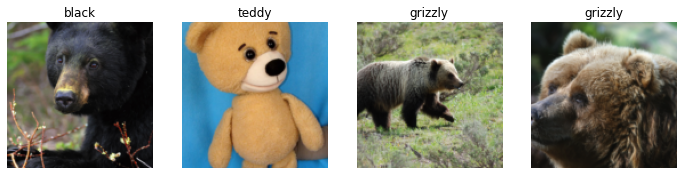

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

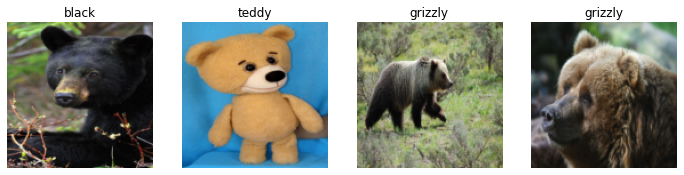

In [12]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

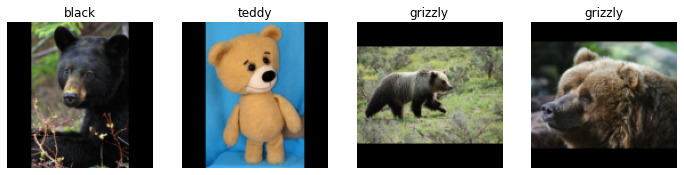

In [13]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

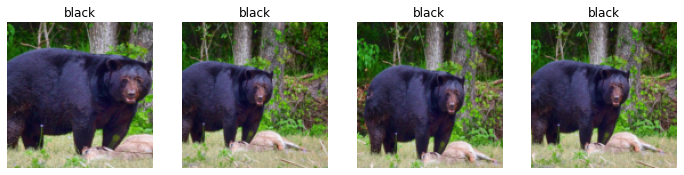

In [14]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

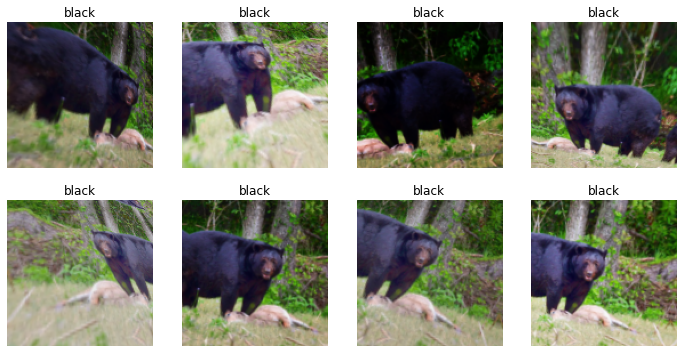

In [15]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [16]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [17]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.996597,0.113721,0.012121,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.094409,0.070830,0.012121,00:45
1,0.077190,0.070770,0.018182,00:45
2,0.061612,0.073486,0.024242,00:45
3,0.053691,0.068159,0.018182,00:45


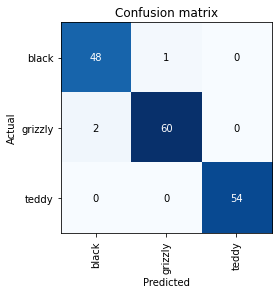

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

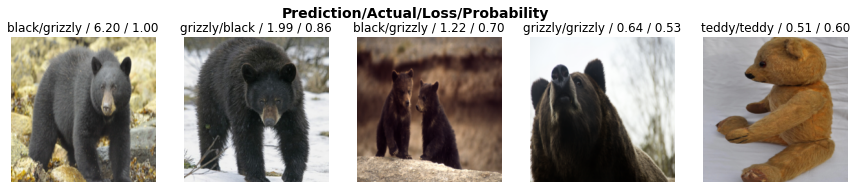

In [19]:
interp.plot_top_losses(5, nrows=1)

In [20]:
learn.export()

In [21]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [23]:
learn_inf = load_learner(path/'export.pkl')

In [25]:
learn_inf.predict('images/bear.jpg')

('grizzly', TensorBase(1), TensorBase([1.1376e-07, 1.0000e+00, 3.9631e-08]))

In [28]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']